# Retrosynthesis Reaction Planning

An interesting application of retrosynthesis prediction is to predict a series of retrosynthetic reactions that break a target molecule down into smaller components. This is done by iteratively applying prediction to new predicted reactants until sufficiently simple molecules are reached. The general algorithm follows the following format:

 * Predict reactants for a given molecule
 * Select top prediction based on heuristic scoring
 * For each reactant molecule in the top prediction, determine if the reactant is sufficiently simple (terminal) or not
 * Repeat predictions on non-terminal reactants
 
Full code is in the `utils.py` file, but this section gives an overview.

## Generating Predictions

The dataset used selects reaction mechanisms by pre-pending a mechanism specific token to a molecule. The following token/mechanisms are contained in the dataset:

    '<RX_1>' : 'Heteroatom Alkylation and Arylation'
    '<RX_2>' : 'Acylation and Related Processes'
    '<RX_3>' : 'C-C Bond Formation'
    '<RX_4>' : 'Heterocycle Formation'
    '<RX_5>' : 'Protection'
    '<RX_6>' : 'Deprotection'
    '<RX_7>' : 'Reduction'
    '<RX_8>' : 'Oxidation'
    '<RX_9>' : 'Functional Group Interconversion'
    '<RX_10>' : 'Functional Group Addition'
    
For a given molecule, we don't know what mechanism will best break it down into simpler reactants, so we try all mechanisms. For a given SMILES string, we make 10 variants, one for each mechanism token. For each variant, we predict with a beam size of 10, generating 100 total predictions for the target product.

## Heuristic Scoring

Once we have predictions, we want to select the best one to move forward with. Here, the model's confidence with the prediction is an important factor, but there are other things to consider. We can add other factors to the overall model score to move predictions in the direction we want.

We want to break down molecules, so we add two terms to bias predictions toward this. One term looks at the difference in carbon rings between reactants and products. Reactants with fewer rings than the product molecule receieve a higher score than reactants with the same number of rings, encouraging a breaking down of the product molecule. We also look at the relative sizes of reactant and product molecules. We would prefer reactions that cause large breakdowns (ie breaking a complex molecule in half) compared to small breakdowns (popping off a single carbon), so we add a term based on the length of the product molecule minus the length of the largest molecule in the predicted reactants.

We also clean up predictions to remove junk predictions. Predictions that do not correspond to a valid SMILES string are thrown out. We also remove any predictions that contain the product molecule or a direct parent molecule. This prevents infinite loops where the model predits A from B, then B from A, repeating infinitely.

The precise balance of scoring terms and their exact form is something that needs to be massaged.

## Evaluating Reactant Molecules

Once we have a final selection of reactants, we determine if the reactants are sufficiently simple or if they require another stage of retrosynthetic breakdown. We use two categories to determine if a molecule is terminal.

Any reactant that is a Grignard reagent is considered terminal. The dataset used to train the model did not contain any grignard creation reactions, and therefore predicting such reactions is out of the scope of the model.

Molecules with less than 11 non-hydrogen atoms are considered terminal.

If all prediction scores for a molecule are below a certain threshold of confidence (ie no good predictions exist), the molecule is considered terminal.

Any reactant that is not terminal is considered "active".

## Running a Full Prediction Tree

To run an entire Retrosynthesis process, we iteratively run predictions over a tree structure. Each node is created by some target product molecule. The 10 reaction token variants are created for the product molecule and predicted over. Predictions for the product variants are stored. Based on the predictions, the product molecule is either considered terminal or assigned a set of reactants.

When reactants are assigned, new nodes are created for each reactant molecule. These nodes are designated as the children of the original product node. The prediction process then repeats.

To make prediction efficient, all active nodes (active meaning the node is not terminal and does not have reactants) are predicted over at the same time.

Nodes are handled by the `Reaction` class in the `utils.py` file, while full Retrosynthesis planning over a tree of nodes is handled by the `Retrosynthesis` class.

In [1]:
from utils import *

In [2]:
molecule = 'C O c 1 c c c ( S ( = O ) ( = O ) N c 2 c c c 3 c ( c 2 ) B ( O ) O C 3 ) c ( [ N + ] ( = O ) [ O - ] ) c 1'
molecule

'C O c 1 c c c ( S ( = O ) ( = O ) N c 2 c c c 3 c ( c 2 ) B ( O ) O C 3 ) c ( [ N + ] ( = O ) [ O - ] ) c 1'

In [3]:
retro = RetroSynthesis(molecule)

In [4]:
# run synthesis runs the iterative prediction process
retro.run_retrosynthesis()

PRED AVG SCORE: -0.0074, PRED PPL: 1.0075
PRED AVG SCORE: -0.0236, PRED PPL: 1.0239
PRED AVG SCORE: -0.0288, PRED PPL: 1.0292


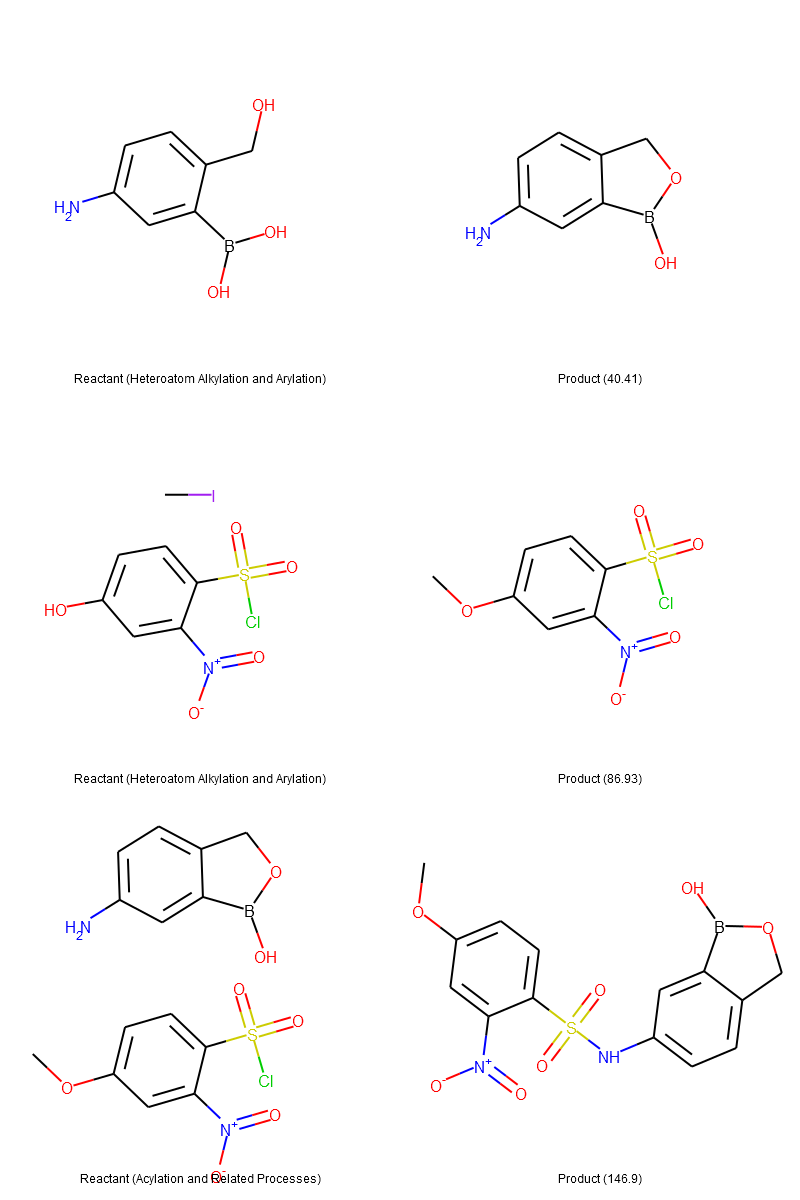

In [5]:
# display_synthesis displays all predicted reactions
retro.display_synthesis()

In [6]:
# the nodes attribute holds a list of all nodes
retro.nodes

[Product: COc1ccc(S(=O)(=O)Nc2ccc3c(c2)B(O)OC3)c([N+](=O)[O-])c1
 Reactants: COc1ccc(S(=O)(=O)Cl)c([N+](=O)[O-])c1.Nc1ccc2c(c1)B(O)OC2
 Reaction Mechanism: Acylation and Related Processes,
 Product: COc1ccc(S(=O)(=O)Cl)c([N+](=O)[O-])c1
 Reactants: CI.O=[N+]([O-])c1cc(O)ccc1S(=O)(=O)Cl
 Reaction Mechanism: Heteroatom Alkylation and Arylation,
 Product: Nc1ccc2c(c1)B(O)OC2
 Reactants: Nc1ccc(CO)c(B(O)O)c1
 Reaction Mechanism: Heteroatom Alkylation and Arylation,
 Product: CI
 Terminal Reactant,
 Product: O=[N+]([O-])c1cc(O)ccc1S(=O)(=O)Cl
 Terminal Reactant,
 Product: Nc1ccc(CO)c(B(O)O)c1
 Terminal Reactant]

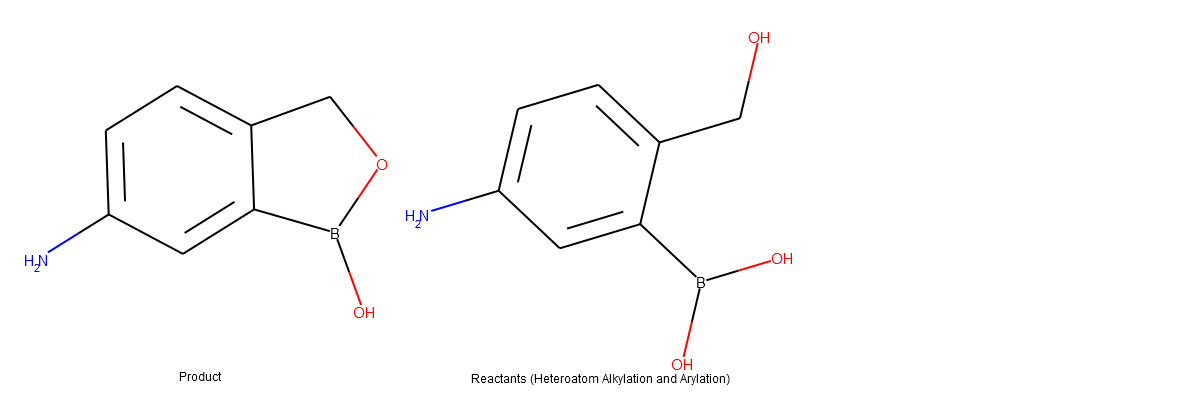

In [6]:
# A given node can display the predicted reaction
retro.nodes[2].display_reaction()

In [7]:
# A node also holds the full prediction dataframe after filtering and score thresholding
retro.nodes[2].prediction_df.head()

,Prediction,Score,Input,Product_Molecule,Mechanism,Prediction_Score
0,N c 1 c c c ( C O ) c ( B ( O ) O ) c 1,-1.096327,<RX_1> N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,<RX_1>,40.409587
1,N c 1 c c c ( C C l ) c ( B ( O ) O ) c 1,-2.348124,<RX_1> N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,<RX_1>,9.554829
2,N c 1 c c c ( C C l ) c ( B ( O ) O ) c 1,-2.561921,<RX_1> N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,<RX_1>,7.715641
3,N c 1 c c c ( C O ) c ( B ( O ) O ) c 1,-2.628432,<RX_1> N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,<RX_1>,7.219155
4,N c 1 c c c ( C O ) c ( B ( O ) O ) c 1,-3.430017,<RX_1> N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,N c 1 c c c 2 c ( c 1 ) B ( O ) O C 2,<RX_1>,3.238637


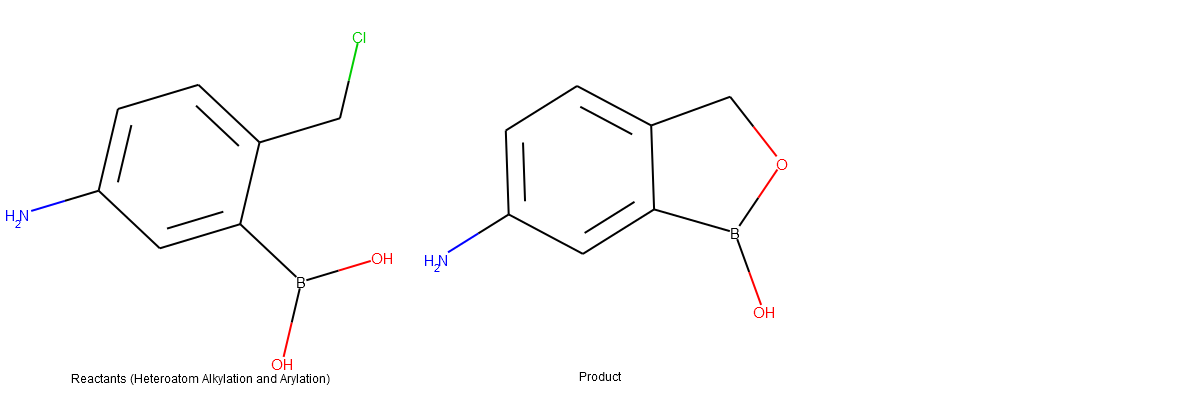

In [8]:
# We can view any prediction in the prediction dataframe by passing the index to the display_prediction function
retro.nodes[2].display_prediction(1)